<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages</a></span></li><li><span><a href="#Density-Profile" data-toc-modified-id="Density-Profile-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Density Profile</a></span></li><li><span><a href="#Initial-Conditions" data-toc-modified-id="Initial-Conditions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Initial Conditions</a></span><ul class="toc-item"><li><span><a href="#IC-with-Jeans-Equation" data-toc-modified-id="IC-with-Jeans-Equation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>IC with Jeans Equation</a></span><ul class="toc-item"><li><span><a href="#Check-the-Primitives" data-toc-modified-id="Check-the-Primitives-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Check the Primitives</a></span></li></ul></li><li><span><a href="#IC-with-Eddington-Inversion" data-toc-modified-id="IC-with-Eddington-Inversion-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>IC with Eddington Inversion</a></span></li></ul></li><li><span><a href="#Measure-the-Equilibrium" data-toc-modified-id="Measure-the-Equilibrium-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Measure the Equilibrium</a></span><ul class="toc-item"><li><span><a href="#With-Jeans-Eq." data-toc-modified-id="With-Jeans-Eq.-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>With Jeans Eq.</a></span></li></ul></li><li><span><a href="#Effect-of-the-Opening-Criteria" data-toc-modified-id="Effect-of-the-Opening-Criteria-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Effect of the Opening Criteria</a></span></li></ul></div>

## Packages

In [2]:
import astropy.units as u
import astropy.constants as const
import scipy.integrate as integ
import scipy
import scipy.interpolate as interp
import scipy.optimize as opt
import scipy.stats as stats
import collections
import h5py
import mystats
import os

from myplt import *

In [3]:
class Units:
    def __init__(self, 
                 ulength=u.kpc.to('cm'), 
                 umass=u.Msun.to('g')*1.0e10, uvel=1.0e5):
        self.uL = ulength * u.cm
        self.uM = umass * u.g
        self.uV = uvel * u.cm / u.s
        self.uT = self.uL / self.uV
        print( 'units: L=%s, M=%s, V=%s, T=%s'%( self.uL, self.uM, self.uV, self.uT ) )
        self._get_const()
    def __getitem__(self, tag):
        return self.consts[tag]
    def _get_const(self):
        self.consts = {
            'G': (const.G / ( self.uL**3 / self.uT**2 / self.uM ) ).to(1).value,
            'Msun': ( u.Msun/self.uM ).to(1)
        }
        print('consts:', ', '.join([ '%s=%s'%(k,v) for k,v in self.consts.items()]) )
units = Units()
        
class CoordsCvt:
    def __init__(self):
        pass
    
    @staticmethod
    def sphere_to_cart(theta, phi):
        return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
    
class RNG:
    def __init__(self):
        pass
    @staticmethod
    def sphere( n ):
        cos_t = 2*RNG.uniform(n, 1.0e-6, 1.0-1.0e-6)-1.0
        t = np.arccos( cos_t )
        phi = 2.0*np.pi*RNG.uniform(n)
        return CoordsCvt.sphere_to_cart( t, phi ).T
    @staticmethod
    def uniform( n, lo=0., hi=1. ):
        return np.random.uniform( low = lo, high=hi, size=n )

def IC_generator(filename, pos, vel, mass):
    npart = len(pos)
    attrs = {
        'BoxSize': 0., 'Flag_Cooling': 0,
        'Flag_Entropy_ICs': np.array([0]*6, dtype=int),
        'Flag_Feedback': 0,
        'Flag_Metals': 0,
        'Flag_Sfr': 0,
        'Flag_StellarAge': 0,
        'HubbleParam': 1.0,
        'MassTable': np.array([0., mass, 0., 0., 0., 0.], dtype=float),
        'NumFilesPerSnapshot': 1,
        'NumPart_ThisFile': np.array([0, npart, 0, 0, 0, 0], dtype=int),
        'NumPart_Total': np.array([0, npart, 0, 0, 0, 0], dtype=int),
        'NumPart_Total_HighWord': np.array([0]*6, dtype=int),
        'Omega0': 0.,
        'OmegaLambda': 0.,
        'Redshift': 0.,
        'Time': 0.
    }
    dsets = {
        'Coordinates': pos,
        'Velocities': vel,
        'ParticleIDs': np.arange(npart, dtype=int)
    }
    
    file = h5py.File( filename, 'w' )
    file_hd = file.create_group('Header')
    file_attrs = file_hd.attrs
    for k, v in attrs.items():
        file_attrs.create(k, data=v)
    grp = file.create_group('PartType1')
    for k, v in dsets.items():
        grp.create_dataset(k, data=v)

units: L=3.085677581467192e+21 cm, M=1.9884754153381439e+43 g, V=100000.0 cm / s, T=3.085677581467192e+16 s
consts: G=43009.17270069976, Msun=9.999999999999999e-11


In [4]:
class Gadget2Param:
    def __init__(self):
        #  Relevant files
        self.InitCondFile = './IC', 's'
        self.OutputDir = 'output/', 's'
        self.EnergyFile         = 'energy.txt', 's'
        self.InfoFile           = 'info.txt', 's'
        self.TimingsFile        = 'timings.txt', 's'
        self.CpuFile            = 'cpu.txt', 's'
        self.RestartFile        = 'restart', 's'
        self.SnapshotFileBase   = 'snapshot', 's'
        self.OutputListFilename = 'parameterfiles/output_list.txt', 's'
        
        # CPU time -limit
        self.TimeLimitCPU       = 36000, 'd'            # = 10 hours
        self.ResubmitOn         = 0, 'd'
        self.ResubmitCommand    = 'my-scriptfile', 's'
        
        # Code options
        self.ICFormat                = 3, 'd'
        self.SnapFormat              = 3, 'd'
        self.ComovingIntegrationOn   = 0, 'd'
        self.TypeOfTimestepCriterion = 0, 'd'
        self.OutputListOn            = 0, 'd'
        self.PeriodicBoundariesOn    = 0, 'd'
        
        # Caracteristics of run
        self.TimeBegin               = 0.0,  'f'              # Begin of the simulation
        self.TimeMax                 = 10.0, 'f'              # End of the simulation
        self.Omega0                  = 0.,   'f'
        self.OmegaLambda             = 0.,   'f'
        self.OmegaBaryon             = 0.,   'f'
        self.HubbleParam             = 1.0,  'f'
        self.BoxSize                 = 0.,   'f'
        
        # Output frequency
        self.TimeBetSnapshot        = 1.0, 'f'
        self.TimeOfFirstSnapshot    = 0.,   'f'
        self.CpuTimeBetRestartFile     = 36000.0, 'f'     # here in seconds
        self.TimeBetStatistics         = 1.0,     'f'
        self.NumFilesPerSnapshot       = 1,       'd'
        self.NumFilesWrittenInParallel = 1,       'd'
        
        # Accuracy of time integration
        self.ErrTolIntAccuracy      = 0.025, 'f'
        self.CourantFac             = 0.15, 'f'     
        self.MaxSizeTimestep        = 0.01 , 'f' 
        self.MinSizeTimestep        = 0.0, 'f'
        
        # Tree algorithm, force accuracy, domain update frequency
        self.ErrTolTheta            = 0.5, 'f'
        self.TypeOfOpeningCriterion = 1,   'd'
        self.ErrTolForceAcc         = 0.005, 'f'
        self.TreeDomainUpdateFrequency    = 0.1, 'f'
        
        #  Further parameters of SPH
        self.DesNumNgb              = 50, 'd'
        self.MaxNumNgbDeviation     = 2,  'd'
        self.ArtBulkViscConst       = 0.8, 'f'
        self.InitGasTemp            = 0.,  'f'           # always ignored if set to 0 
        self.MinGasTemp             = 0.,  'f'
        
        # Memory allocation
        self.PartAllocFactor       = 1.5, 'f'
        self.TreeAllocFactor       = 0.8, 'f'
        self.BufferSize            = 25,  'd'            # in MByte
        

        # System of units
        self.UnitLength_in_cm         = 3.085677581467192e21, 'g'        #  1.0 kpc 
        self.UnitMass_in_g            = 1.988409870698051e43, 'g'        #  1.0e10 solar masses 
        self.UnitVelocity_in_cm_per_s = 1.0e5, 'g'                       #  1 km/sec 
        self.GravityConstantInternal  = 0.,    'f'
        
        # Softening lengths
        self.MinGasHsmlFractional = 0.25, 'f'

        self.SofteningGas       = 0., 'f'
        self.SofteningHalo      = 1.0, 'f'
        self.SofteningDisk      = 0.4,  'f'
        self.SofteningBulge     = 0.,   'f'           
        self.SofteningStars     = 0.,   'f'
        self.SofteningBndry     = 0.,   'f'

        self.SofteningGasMaxPhys       = 0., 'f'
        self.SofteningHaloMaxPhys      = 1.0, 'f'
        self.SofteningDiskMaxPhys      = 0.4, 'f'
        self.SofteningBulgeMaxPhys     = 0., 'f'           
        self.SofteningStarsMaxPhys     = 0., 'f'
        self.SofteningBndryMaxPhys     = 0., 'f'

        self.MaxRMSDisplacementFac = 0.2, 'f'
    def set(self, key, val):
        if key not in self.__dict__:
            raise Exception('key %s not valid'%key)
        oldval = self.__dict__[key]
        self.__dict__[key] = (val, oldval[1])
    def get(self, key, val):
        return self.__dict__[key]
    def show(self):
        for k,v in self.__dict__.items():
            if k[:2] != '__':
                print( '%s \t\t %%%s'%(k, v[1])%(v[0]) )
    def dump(self, fname):
        f = open( fname, 'w' )
        for k,v in self.__dict__.items():
            if k[:2] != '__':
                f.write( '%s \t\t %%%s\n'%(k, v[1])%(v[0]) )

## Density Profile

In [55]:
class NFWProfile:
    def __init__(self, mass, rs, rt=None, rw=None, r0=None, units=None ):
        self.mass = mass
        self.rs = rs
        self.rt = rt if rt else 15.0*rs
        self.rw = rw if rw else rs
        self.r0 = r0 if r0 else 1.0e-5 * rs
        
        self.xs, self.xt, self.xw, self.x0 = 1.0, \
            self.rt/self.rs, self.rw/self.rs, self.r0 / self.rs
        self.ys, self.yt, self.yw, self.y0 = 0., \
            np.log( self.xt ), np.log( self.xw ), np.log( self.x0 )
        self.vols = 4.0/3.0*np.pi*rs*rs*rs
        
        self.units = units if units else Units()
        self.G =  self.units['G']
        
        #y1, y2 = self.y0, self.yt
        #ys = np.linspace( y1, y2, 1500 )
        ys = np.hstack( ( 
            np.linspace(self.y0, np.log(self.xt-self.xw), 1500 ), 
            np.log( np.linspace(self.xt-self.xw+0.001*self.xw, self.xt, 100) ) 
        ) )
        self._data = {'ys': ys }
        self.interp = interp.PchipInterpolator
        
        self._interp_IM()
        self._interp_IV()
        self._interp_Isigma()
        self._interp_If()
    def __getitem__(self, key):
        return self._data[key]
    def rho(self, r):
        return self.rho0 * self._Irho( r/self.rs )
    def M(self, r):
        return 3.0*self.Ms*self._IM( r/self.rs )
    def V(self, r):
        return self.V0 + 3.0 * self.Vs * self._IV( r/self.rs )
    def sigma2(self, r):
        x = r/self.rs
        ans = 3.0*self.Vs/self._Irho(x)*self._Isigma(x)
        if isinstance(ans, collections.Iterable):
            ans[ ans < 0. ] = 0.
        else:
            if ans < 0. : ans = 0.
        return ans
    def r_at_M(self, M):
        ans = self._inv_IM( M/(3.0*self.Ms) ) * self.rs
        if isinstance(ans, collections.Iterable):
            ans[ ans < 0. ] = 0.
            ans[ ans > self.rt ] = self.rt
        else:
            if ans < 0.: ans = 0.
            if ans > self.rt: ans = self.rt
        return ans
    def fE(self, E):
        xE = np.log(self['IE_eps'] + (E-self.V0)/(3.0*self.Vs))
        ans = self.fE0 * self._IfxE(xE)
        if isinstance(ans, collections.Iterable):
            ans[ans < 0.] = 0.
        else:
            if ans < 0.: ans = 0.
        return ans
    def _Irho(self, x):
        xp1 = 1.0+x
        return 1.0 / ( x*xp1*xp1 ) * scipy.special.erf( (self.xt-x)/self.xw )
    def _Irhoy(self, y):
        return self._Irho( np.exp(y) )
    def _interp_IM(self):
        Irhoy = self._Irhoy
        def f( y ):
            return np.exp( 3.0*y ) * Irhoy(y)
        ys = self['ys']
        IMys = [ integ.quad( f, self.y0, y )[0] for y in ys ]
        _IMy = self.interp(ys, IMys)
        self._IMy = _IMy
        self._IM = lambda x: _IMy( np.log(x) )
        self.Ms = self.mass / (3.0*IMys[-1])
        self.rho0 = self.Ms / self.vols
        self.Vs = self.G * self.Ms / self.rs
        print('interp for M done, IM = [%f...%f]'%( IMys[0], IMys[-1] ))
        _inv_IMy = self.interp( IMys, ys )
        self._inv_IMy = _inv_IMy
        self._inv_IM = lambda IM: np.exp(_inv_IMy(IM) )
        self._data['IMys'] = np.array(IMys)
        self._data['Irhoys'] = self._Irhoy( ys )
    def _interp_IV(self):
        IMy = self._IMy
        def f( y ):
            return IMy(y) / np.exp(y)
        ys = self['ys']
        IVys = [ integ.quad( f, self.y0, y )[0] for y in ys ]
        _IVy = self.interp( ys, IVys )
        self._IVy = _IVy
        self._IV = lambda x: _IVy( np.log(x) )
        self.V0 = -3.0*self.Vs*IVys[-1]
        print('interp for V done, IV = [%f...%f]'%( IVys[0], IVys[-1] ))
        self._data['IVys'] = np.array(IVys)
    def _interp_Isigma(self):
        IMy, Irhoy = self._IMy, self._Irhoy
        def f(y):
            return IMy(y)*Irhoy(y) / np.exp(y)
        ys = self['ys']
        Isigmays = [ integ.quad( f, y, self.yt )[0] for y in ys ]
        _Isigmay = self.interp(ys, Isigmays)
        self._Isigmay = _Isigmay
        self._Isigma = lambda x: _Isigmay( np.log(x) )
        print('interp for sigma done, Isigma = [%f...%f]'%( Isigmays[0], Isigmays[-1] ))
        self._data['Isigmays'] = np.array(Isigmays)
    def _interp_If(self):
        Irho_eps = IV_eps = IE_eps = Int_eps = q_eps = 0.01
        self._data.update( dict(Irho_eps=Irho_eps, 
                IV_eps=IV_eps, IE_eps=IE_eps, Int_eps=Int_eps, q_eps=q_eps) )
        
        # make the integrand
        # It consists of a detivative drho / dV, or dx_rho / dx_V
        Irhos, IVs = self['Irhoys'], self['IVys']
        xrhos, xVs = np.log( Irho_eps + Irhos ), np.log( IV_eps + IVs )
        _xrhoxV = self.interp( xVs, xrhos )
        _dxrhoxV = _xrhoxV.derivative()
        
        # get integration
        expq_eps = np.exp(q_eps)
        def f(q, IE):
            expq = np.exp(q)
            IV = IE + (expq - expq_eps)**2
            xV = np.log( IV_eps + IV )
            xrho = _xrhoxV(xV)
            return expq * _dxrhoxV( xV ) * np.exp(xrho) / np.exp(xV)
        IEs = IVs + 0.
        IEt = IEs[-1]        
        Ints = np.array([ integ.quad( 
            (lambda q: f(q, IE)), 
            q_eps, np.log(np.sqrt(IEt-IE)+expq_eps), limit=1000 )[0] 
            for IE in IEs ])
        
        # make derivative again
        xEs = np.log( IE_eps + IEs ) 
        xInts = np.log( Int_eps - Ints )
        _xIntxE = self.interp( xEs, xInts )
        _dxIntdxE = _xIntxE.derivative()
        #dxIntdxE = _xIntxE.derivative()( xEs )
        #for i in range(len(xEs)-1):
        #    if dxIntdxE[i+1] < dxIntdxE[i]: dxIntdxE[i+1] = dxIntdxE[i]
        #_dxIntdxE = self.interp( xEs, dxIntdxE )
        self._data.update(dict(xEs=xEs,xInts=xInts))
        
        print('interp for fE done, xE = [%f...%f], xInt = [%f...%f]'%( \
            xEs[0], xEs[-1], xInts[0], xInts[-1] ))
        def _IfxE(xE):
            xInt = _xIntxE(xE)
            dxIntdxE = _dxIntdxE(xE)
            return - np.exp(xInt) / np.exp(xE) * dxIntdxE
        self._IfxE = _IfxE
        self.fE0 = 2.0/( np.sqrt(8.0)*np.pi*np.pi ) * self.rho0 / ( 3.0*self.Vs )**1.5

In [56]:
totmass = 1.0e2
rs = 10.0
nfw = NFWProfile(totmass, rs)

units: L=3.085677581467192e+21 cm, M=1.9884754153381439e+43 g, V=100000.0 cm / s, T=3.085677581467192e+16 s
consts: G=43009.17270069976, Msun=9.999999999999999e-11
interp for M done, IM = [0.000000...1.801137]
interp for V done, IV = [0.000000...0.815079]


/home/yangyao/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


interp for sigma done, Isigma = [4.691284...0.000000]


/home/yangyao/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:134: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


interp for fE done, xE = [-4.605170...-0.192276], xInt = [18.749071...-4.605170]


## Initial Conditions

### IC with Jeans Equation 

In [41]:
class JeansIC:
    def __init__(self, profile):
        self.profile = profile
        self.r0, self.rt = profile.r0, profile.rt
        self.mass = profile.mass
    def get(self, n):
        M = RNG.uniform( n, 1.0e-4, 0.9999 ) * self.mass
        r = self.profile.r_at_M( M )
        sigma = np.sqrt(self.profile.sigma2( r ))
        
        pos = RNG.sphere(n) * r.reshape((n,1))
        vel = np.random.randn(n, 3) * sigma.reshape((n,1))
        vel = vel - vel.mean( axis=0 )
        partmass = self.mass / n
        print('range: pos=', np.max(np.abs(pos)), ', vel=', np.max(np.abs(vel)), 
              ', particle mass=', partmass)
        return pos, vel, partmass

#### Check the Primitives

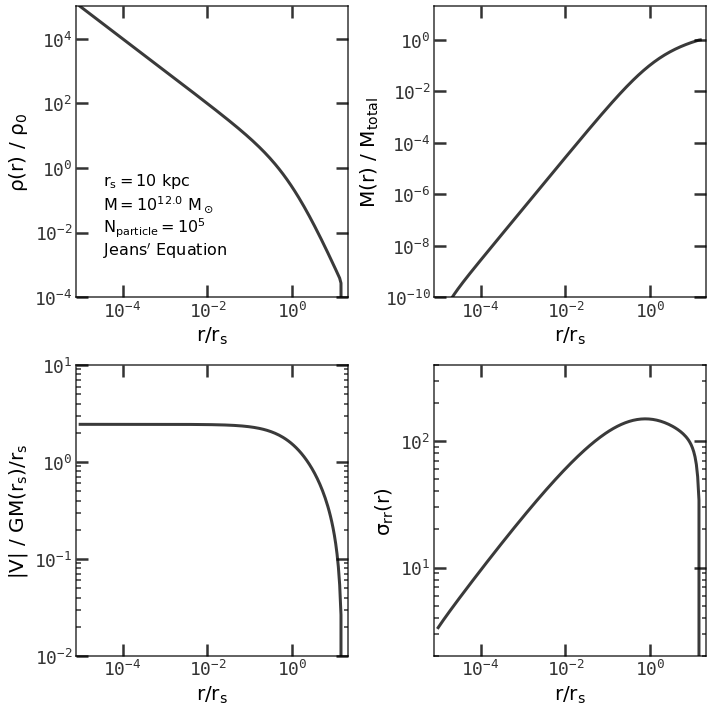

In [42]:
x1, x2 = nfw.x0, nfw.xt
rs = nfw.rs

r = np.logspace( np.log10(x1), np.log10(x2), 200) * rs
rho = nfw.rho( r ) / nfw.rho0
M = nfw.M( r ) / ( nfw.mass )
V = nfw.V( r ) / ( nfw.Vs )
sigma = np.sqrt(nfw.sigma2( r ))

_, axs = m_get_figure((10, 10), 2, 2)
axs = axs[0] + axs[1]

lims = [[1.0e-4, 1.0e5], [1.0e-10, 2.0e1], [1.0e-2, 1.0e1], [2.0, 4.0e2]]
labs = [ r'$\rm \rho(r)\ /\ \rho_0$', r'$\rm M(r)\ /\ M_{total} $', r'$\rm |V|\ /\ GM(r_s)/r_s $', r'$\rm \sigma_{rr}(r) $' ]
for i,d in enumerate([rho, M, V, sigma]):
    ax = axs[i]
    ax.plot( r/rs, np.abs(d), c=mycms2_r[0], lw=3. )
    m_set_lim(ax, [8.0e-6, 20], lims[i])
    m_set_label(ax, r'$\rm r/r_s$', labs[i])

txposs( axs[0], [r'$\rm r_s=10\ kpc$', r'$\rm M=10^{12.0}\ M_\odot$', r'$\rm N_{particle}=10^5$', r"$\rm Jeans'\ Equation$"], (.1, .4), (0. -.08), 'k' )

for ax in axs:
    m_set_scale(ax,'log', 'log')

plt.tight_layout()
plt.savefig('output/jean_IC_recipe.pdf')
plt.show()

In [30]:
n = 100000
pos, vel, m = JeansIC( nfw ).get(n)
IC_generator('./run_jeans_eq/IC.hdf5', pos, vel, m)

range: pos= 147.4592252333532 , vel= 667.0448757027451 , particle mass= 0.001


Initial Conditions for testing opening criteria and momentum conservation

In [9]:
fbase = './open_crit/ICs/IC_N50000_M12'
n = 50000
for i in range(10):
    pos, vel, mass = JeansIC( nfw ).get(n)
    print( pos[0], vel[0], m )
    IC_generator( fbase + '.%d.hdf5'%i, pos, vel, mass )

[ 15.89845769 -10.15678515 -10.87964869] [-195.83209029 -232.06560593    8.45638201] 0.001
[ 62.73522145 -33.81199783  18.75681964] [-172.20959322  165.84187656   83.93393365] 0.001
[ -3.89824499 -38.42584852  42.62239089] [-245.49619638   46.82303533  165.08238424] 0.001
[  2.04507638  -1.21391985 -10.51538544] [ 25.89572793  15.25493878 -43.4026243 ] 0.001
[11.07548757 -0.10834332  3.17072012] [-112.88626559  -25.22603714 -263.53794722] 0.001
[-16.93113925  27.74282302   5.49729994] [ 4.77332722 92.69592649 43.07458714] 0.001
[-3.86203107 -1.4055549  -1.48948517] [ 71.8945567  -66.84020207 184.16483663] 0.001
[21.52527614 75.97346187  7.94513102] [212.90593541 121.71447192 241.60818968] 0.001
[-68.03848082  52.64441728 -26.72290667] [-45.05766351  86.96613521 -34.90352556] 0.001
[15.09054843  1.1300223  13.89703647] [ -41.81841416 -333.04859619 -107.18620951] 0.001


### IC with Eddington Inversion

In [57]:
class EddInv:
    def __init__(self, prof):
        self.prof = prof
        self.mass = prof.mass
        self.r0, self.rt = prof.r0, prof.rt
        self.Et = prof.V( prof.rt )
        self.f_optimize_target = lambda x,y: 1.5*x - 0.5*x*x*x - y
    def vmax(self, V):
        return np.sqrt( 2.0*(self.Et - V) )
    def one_sample(self):
        R0, R1, R2, R3 = RNG.uniform( 4, 1.0e-4, 0.9999 )
        M = R0 * self.mass
        r = self.prof.r_at_M( M )
        V = self.prof.V(r)
        vmax = self.vmax(V)
        
        z = np.sqrt(R1)
        vr = opt.root_scalar( self.f_optimize_target, 
            args=(R2,), bracket=[0., 1.], method='brentq' ).root * vmax
        vr2 = vr*vr
        vmax2 = vmax*vmax
        vt2 = z*z*( vmax2-vr2 )        
        fs = self.prof.fE( np.array([ (vr2+vt2)/2.0+V, V ]) )
        reject_thres = fs[0] / (fs[1]+1.0e-15)
        
        if R3 > reject_thres: return None
        vt = np.sqrt(vt2)
        return r, vr, vt
    def samples( self, n ):
        s = []
        cnt = 0
        while len(s) < n:
            sample = self.one_sample()
            cnt += 1
            if sample: s.append(sample)
        print('sampling rate = ', n/cnt)
        r, vr, vt = np.array(s).T
        pos = RNG.sphere(n) * r.reshape((n,-1))
        
        rn = RNG.uniform(n)
        vr[ rn<.5 ] = -vr[ rn<.5 ]
        
        phi = 2.0*np.pi*RNG.uniform(n)
        vx = np.cos(phi)*vt
        vy = np.sin(phi)*vt
        vz = vr
        vel = np.array([vx,vy,vz]).T
        vel = vel - vel.mean( axis=0 )
        partmass = self.mass / n
        print('range: pos=', np.max(np.abs(pos)), ', vel=', np.max(np.abs(vel)), 
              ', particle mass=', partmass)
        return pos, vel, partmass

In [58]:
eddinv = EddInv(nfw)

In [61]:
Nsample = 100000
pos, vel, partmass = eddinv.samples(Nsample)
IC_generator( 'run_eddington_inv/IC.hdf5', pos, vel, partmass )

sampling rate =  0.3230600245525619
range: pos= 148.56993446289096 , vel= 524.7515154518109 , particle mass= 0.001


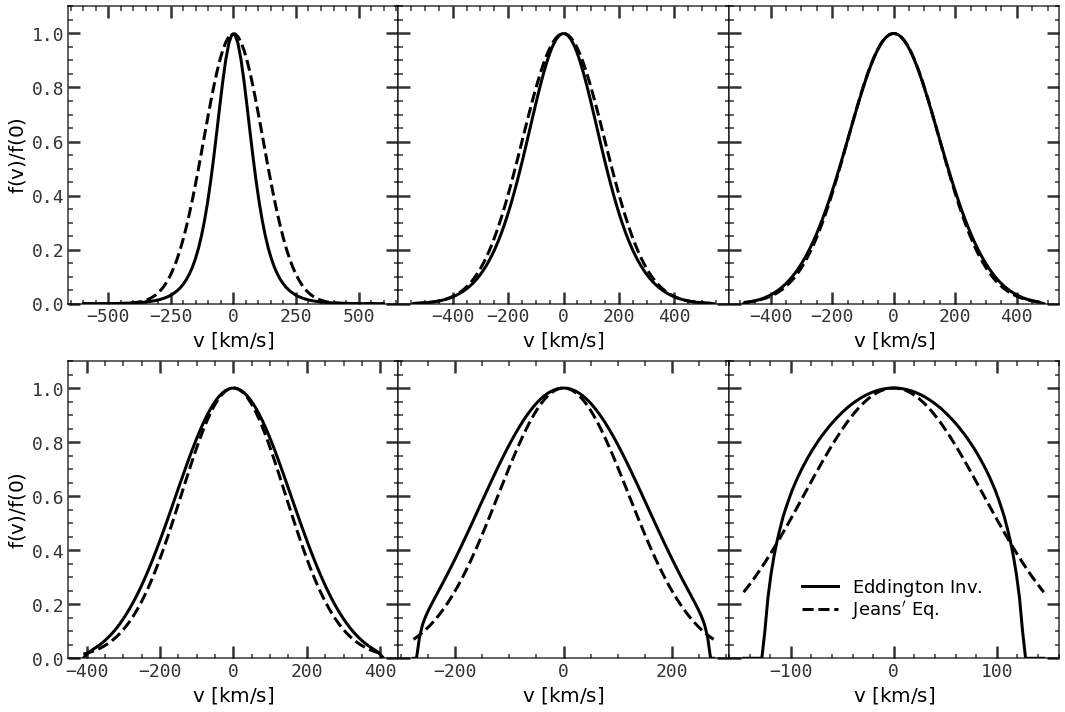

In [60]:
fig, axs = plt.subplots( 2, 3, figsize=(15,10), sharey=True, gridspec_kw={'wspace':0.} )
axs = axs.flat

lims = [0.99, 0.99, 0.99, 0.98, 0.96, 0.9]
#lims = [0.99]*6
for ir, xr in enumerate(np.array([0.1, 0.5, 1, 2, 5, 10])):
    ax = axs[ir]
    
    r = nfw.rs * xr
    V = nfw.V( r )
    vmax = eddinv.vmax( V ) * lims[ir]
    v = np.linspace( -vmax, vmax, 100 )
    fE = nfw.fE( V + 0.5*v*v ) / nfw.fE( V )
    ax.plot( v, fE, c='k', lw=3., label=r'$\rm Eddington\ Inv.$' )
    
    sigma = np.sqrt(nfw.sigma2( r ))
    rv = stats.norm(scale=sigma)
    ax.plot( v, rv.pdf( v ) / rv.pdf(0), c='k', lw=3., ls='--', label=r"$\rm Jeans'\ Eq.$" )
    m_set_label(ax, r'$\rm v\ [km/s]$')
    if ir in (0,3): m_set_label(ax, y=r'$\rm f(v)/f(0)$')
    
m_set_lim(axs[0], y=[0., 1.1])
axs[5].legend(loc=(.20, .1), frameon=False, labelspacing=0., fontsize=18)

plt.tight_layout()
#plt.savefig('output/compare_recipe.pdf')
plt.show()

## Measure the Equilibrium

In [23]:
class DumpedSet:
    def __init__(self, fname):
        f = h5py.File(fname, 'r')
        pos = np.array(f['PartType1/Coordinates'])
        vel = np.array(f['PartType1/Velocities'])
        V = np.array(f['PartType1/Potential'])
        t = f['Header'].attrs['Time']
        npart = f['Header'].attrs['NumPart_ThisFile'][1]
        
        T = np.sum(vel * vel, axis=1) / 2.0
        r = np.sqrt(np.sum(pos * pos, axis=1))
        
        virial_ratio = -2.0 * T.sum() / ( V.sum()*0.5 )
        q = (.1, .25, .5, .75, .9, .98)
        r_quantile = np.quantile( r, q )
        E = T.sum() + V.sum()*0.5
        
        COM = pos.mean(axis=0)
        pos_rel = pos - COM
        r_COM = np.sqrt( np.sum(COM*COM) )
        
        vel_COM = vel.mean(axis=0)
        vel_rel = vel - vel_COM
        v_COM = np.sqrt( np.sum(vel_COM*vel_COM) )
        
        L = np.cross( pos_rel, vel_rel ).sum( axis=0 )
        L_COM = np.sqrt( np.sum(L*L) )
        
        
        self.stats = {'-2T/V': virial_ratio, 'q': q, 'r_quantile': r_quantile, 'E': E, 't':t, 'npart': npart, 'r_COM': r_COM, 'v_COM': v_COM, 'L_COM': L_COM}
    def get_stats(self, tag):
        return self.stats[tag]
    
class DumpedSets:
    def __init__(self, fbase, nfiles, rs = 10.0, units = Units()):
        ts = []
        Es = []
        qs = []
        r_quantiles = []
        virial_ratios = []
        xs = []
        vs = []
        Ls = []
        npart = None
        for i in range(nfiles):
            d = DumpedSet(fbase + '/snapshot_%.3d.hdf5'%i)
            t, E, q, r_q, virial = d.stats['t'], d.stats['E'], d.stats['q'], d.stats['r_quantile'], d.stats['-2T/V']
            x, v, L = d.stats['r_COM'], d.stats['v_COM'], d.stats['L_COM']
            ts.append( (t*units.uT/u.Gyr).to(1).value )
            Es.append(E)
            qs.append(q)
            r_quantiles.append(r_q / rs)
            virial_ratios.append(virial)
            xs.append(x)
            vs.append(v)
            Ls.append(L)
            npart = d.stats['npart']
        self.stats = {'-2T/V': virial_ratios, 'q': qs, 'r_quantile': r_quantiles, 'E': Es, 't':ts, 'npart':npart, 'x': xs, 'v':vs, 'L':Ls}

units: L=3.085677581467192e+21 cm, M=1.9884754153381439e+43 g, V=100000.0 cm / s, T=3.085677581467192e+16 s
consts: G=43009.17270069976, Msun=9.999999999999999e-11


In [66]:
dsets_jeans = DumpedSets('./run_jeans_eq/output/', 12).stats
dsets_edd = DumpedSets('./run_eddington_inv/output/', 12).stats

### With Jeans Eq.

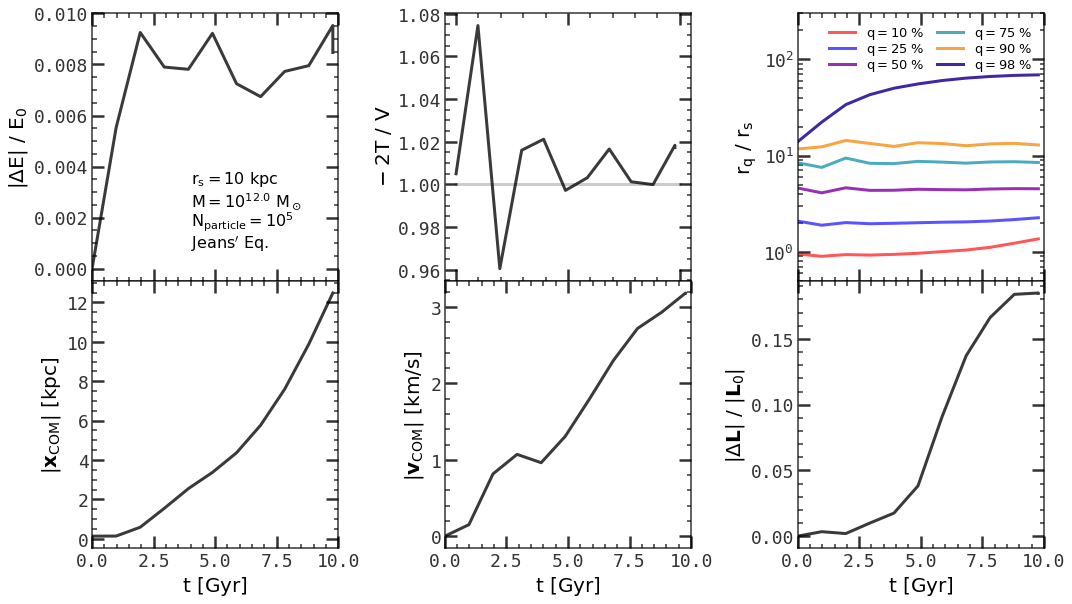

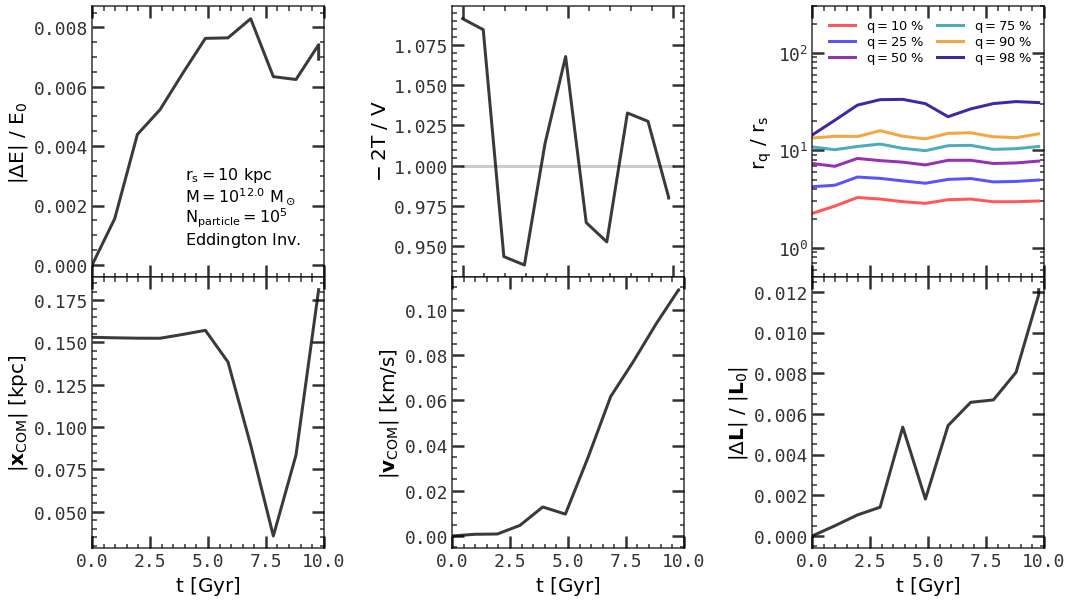

In [68]:
labels = [ r"$\rm Jeans'\ Eq.$", r'$\rm Eddington\ Inv.$']
outs = ['output/measure_stats_jeans.pdf', 'output/measure_stats_edd.pdf']

for idset, dset in enumerate([ dsets_jeans, dsets_edd ]) :
    fig, axs = plt.subplots( 2, 3, figsize=(15, 8.5), gridspec_kw = { 'hspace':0 } )
    axs = axs.flat
    
    Nsamples = dset['npart']
    t = dset['t']
    E = np.abs( dset['E'] )
    virial = dset['-2T/V']
    q = dset['q'][0]
    r_q = np.array(dset['r_quantile']).T
    x_com = dset['x']
    v_com = dset['v']
    L = dset['L']

    ax = axs[0]
    dE = np.abs(E - E[0])/E[0]
    ax.plot( t, dE, c=mycms2[-1] )
    m_set_lim(ax, [0, 10] )
    m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm |\Delta E|\ /\ E_0 $')


    ax = axs[1]
    ax.plot( t, virial, c=mycms2[-1] )
    ax.plot( [0., 10.], [1.0, 1.0], c=[0,0,0,.2], lw=3. )
    m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm -2T\ /\ V$')

    ax = axs[2]
    for i in range(len(r_q)):
        ax.plot( t, r_q[i], c=mycms2[i], label=r'$\rm q = %.0f\ \%%$'%( q[i]*100 ) )
    ax.legend(loc='best', ncol=2, labelspacing=0, columnspacing=1., frameon=False, fontsize=13)
    m_set_lim(ax,  [0., 10], [0.5, 3.0e2])
    m_set_scale(ax, y='log')
    m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm r_{q}\ /\ r_s $')

    ax = axs[3]
    ax.plot( t, x_com, c=mycms2[-1] )
    m_set_lim(ax,  [0., 10] )
    m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm |{\bf x}_{COM}|\ [kpc]$')

    ax = axs[4]
    ax.plot( t, v_com, c=mycms2[-1] )
    m_set_lim(ax,  [0., 10] )
    m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm |{\bf v}_{COM}|\ [km/s]$')

    ax = axs[5]
    dL = np.abs( L - L[0] ) / np.abs(L[0])
    ax.plot( t, dL, c=mycms2[-1] )
    m_set_lim(ax,  [0., 10] )
    m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm  |\Delta{\bf L}|\ /\ |{\bf L}_0| $')

    txposs( axs[0], [r'$\rm r_s=10\ kpc$', \
            r'$\rm M=10^{12.0}\ M_\odot$', r'$\rm N_{particle}=10^5$', labels[idset]], (.4, .38), (0. -.08), 'k' )

    for ax in axs[:3]:
        ax.set_xticklabels([])

    plt.tight_layout()
    plt.savefig(outs[idset])
    plt.show()

## Effect of the Opening Criteria

In [11]:
for i in range(9):
    for j in range(10):
        os.system( 'mkdir -p open_crit/runs_alpha%d.%d/output'%( i, j ) )

In [27]:
tbegin = 0.
tsnap = 5.0
tmax = 5.01
angle = 0.2
finit_base = '../ICs/IC_N50000_M12'
alphas = [ 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5 ]

In [12]:
pfile = Gadget2Param()

pfile.set( 'TimeOfFirstSnapshot', tbegin )
pfile.set( 'TimeBetSnapshot', tsnap )
pfile.set( 'TimeMax', tmax )
pfile.set( 'ErrTolTheta', angle )
for ialpha, alpha in enumerate(alphas):
    for j in range(10):
        finit = finit_base + '.%d'%j
        pfile.set('InitCondFile', finit)
        pfile.set('ErrTolForceAcc', alpha)
        pfile.dump( 'open_crit/runs_alpha%d.%d/param.txt'%( ialpha, j) )

In [24]:
def hms2s(s):
    hms = [ int(i) for i in s.strip('\n').split(':') ]
    return hms[0] * 3600 + hms[1] * 60  + hms[2]
def hms2h(s):
    return hms2s(s) / 3600.0

def find_xvt( filebase, ialpha, j, nfiles=3 ):
    filepath = filebase +  '%d.%d'%( ialpha, j )
    stats = DumpedSets( filepath + '/output/', nfiles ).stats
    x, v = stats['x'][-2], stats['v'][-2]

    path = os.popen( 'ls ' + filepath + '.*' ).read().strip('\n')
    with open( path, 'r' ) as f:
        l = f.readlines()
        t1 = hms2h(l[0])
        t2 = hms2h(l[-1])
        dt = t2-t1
    return x,v,dt
def find_xvt_s( filebase, nalpha, nj1, nj2, nfiles=3 ):
    xvts = np.array([ find_xvt(filebase, ialpha, j) \
                     for ialpha in range(nalpha) for j in range(nj1, nj2) ], dtype=float)
    x,v,t = xvts.T
    x = x.reshape((nalpha, nj2-nj1))
    v = v.reshape(x.shape)
    t = t.reshape(x.shape)
    return x,v,t

In [25]:
x,v,t = find_xvt_s('open_crit/runs_alpha', 9, 0, 10)
t[0,0] = t[0,1:].mean()
t[4,1] = t[4,2:].mean()
t *= 16

x, xe = x.mean(1), x.std(1)
v, ve = v.mean(1), v.std(1)
t, te = t.mean(1), t.std(1)

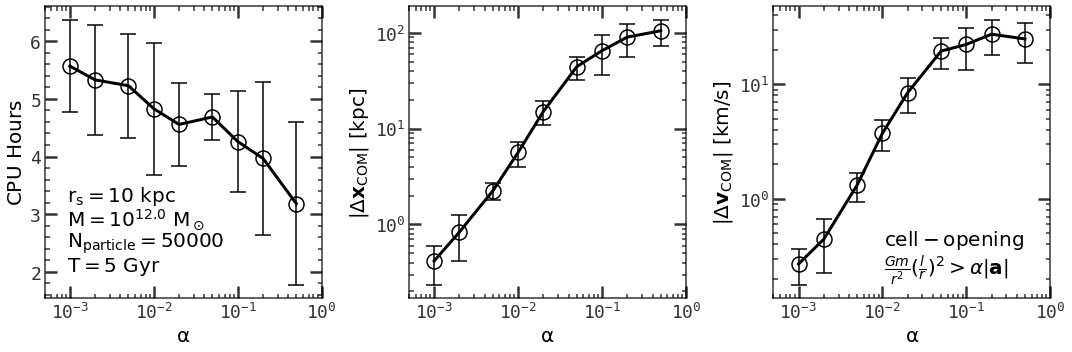

In [28]:
fig, axs = plt.subplots( 1, 3, figsize=(15, 5) )
axs = axs.flat

ylabs = [r'CPU\ Hours', r'|\Delta {\bf x}_{COM}|\ [kpc]', r'|\Delta {\bf v}_{COM}|\ [km/s]']
for i, (d, de) in enumerate( zip([t,x,v], [te,xe,ve]) ):
    ax = axs[i]
    ax.errorbar( alphas, d, yerr=de, c='k', capthick=.5, capsize=8, elinewidth=1.5,
        lw=3., fmt='-o', markersize=15, markerfacecolor='none', markeredgewidth=1.5 )
    m_set_label(ax, r'$\rm \alpha$', r'$\rm %s$'%( ylabs[i] ), fontsize=20)
    m_set_lim(ax, [5.0e-4, 1.0])
    
txposs( axs[2], [ r'$\rm cell-opening$', r'$ \frac{Gm}{r^2}(\frac{l}{r})^2 > \alpha|{\bf a}|$' ],
       (.4, .2), (0., -.1), 'k', 20)
txposs( axs[0], [r'$\rm r_s=10\ kpc$', r'$\rm M=10^{12.0}\ M_\odot$', \
        r'$\rm N_{particle}=50000$', r'$\rm T=5\ Gyr$'], (.08, .35), (0. -.08), 'k', 20 )
    
for ax in axs:
    m_set_scale(ax, x='log')
for ax in axs[1:]:
    m_set_scale(ax, y='log')
    
plt.tight_layout()
plt.savefig('output/open_crit.pdf')
plt.show()